In [4]:
#Import packages
#---------------------------------------
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
import warnings
import random
import arviz as az
import pymc as pm
warnings.filterwarnings("ignore", category=RuntimeWarning) 

#Import your modules
#---------------------------------------

import admin_functions as adfn
import cell_decomp_func as cdfn

# Define paths
#----------------------------------------------------------------------
Fcode = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
Fdata = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
Fdoc = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/'
F10t2 = '/Volumes/Dominic 10tb2/'
Ftm = '/Volumes/Dominic Time Machine/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'

%load_ext autoreload
sys.version

'3.7.16 (default, Jan 17 2023, 09:28:58) \n[Clang 14.0.6 ]'

In [5]:
#Define parameters of simulated data
n_clusts = 10
n_genes = 200
n_cells = 500

#Sample random rates from a uniform distribution for each class and each gene
rate_mat = np.zeros((n_clusts, n_genes))
rate_mat = np.random.uniform(low=0, high=50, size=(rate_mat.shape)).astype(int)
cell_rate_mat = np.repeat(rate_mat, int(n_cells/n_clusts), axis=0) #get the rates for each cell - n cells in each group with same rates

#Sample from Poisson for each cell given its cell type
cell_counts = np.random.poisson(cell_rate_mat, size=cell_rate_mat.shape)

In [7]:
#Generate spots
orig_cells = np.arange(0,cell_counts.shape[0]) 
random.seed(10)
random.shuffle(orig_cells) #randomly shuffle indeces

#split into n spots
chunk_size = []

for f in range(1,10):
    chunk_size = np.append(chunk_size, np.full(int(np.random.uniform(20, 60)), f)) #change random sample range to alter number of spots
    if sum(chunk_size) >= n_cells:
        break

chunk_size = chunk_size[np.cumsum(chunk_size) <= n_cells] #reduce groups to match number of cells
groups = np.split(orig_cells, np.append(np.cumsum(chunk_size), n_cells+1).astype(int))#group by chunk size
n_spots = len(groups)

In [8]:
#Create simulated spots and calculate true proportions
spots = np.zeros((len(groups), cell_counts.shape[1])) #spots x genes
prop_vec = np.zeros((len(groups),n_clusts))

#loop over each group
for g in range(len(groups)):
    spots[g] = np.sum(cell_counts[groups[g]], axis=0) #generate mix of gene expression
    prop_vec[g] = cdfn.proportions((groups[g]/int(n_cells/n_clusts)).astype(int), n_clusts) #calculate the true proportions

In [9]:
#Calculate mean gene expression per group
curr = 0
ref_exp = np.zeros((n_clusts, n_genes))
for i in range(n_clusts):
    ref_exp[i] = np.mean(cell_counts[curr:curr+int(n_cells/n_clusts),:], axis=0)
    curr+=int(n_cells/n_clusts)

In [10]:
#Run without logs
basic_model=pm.Model()

with basic_model:
    
    # alpha=pm.MvNormal("alpha", mu=0, cov=np.ones((200,200)), shape=(200,50))
    beta=pm.HalfNormal("beta", sigma=1, shape=(n_spots, n_clusts))
    
    lmd=pm.math.dot(beta, ref_exp)    

    #Calculate total counts to get Poisson rates
    N = np.sum(spots, axis=1) 
    N = np.asarray([N for i in range(n_genes)]).T #Repeat total counts across columns for elementwise multiplication

    #Likelihood of observed data given Poisson rates
    y=pm.Poisson("y", mu=lmd*N, observed=spots)
    

In [12]:
with basic_model:
    idata=pm.sample(draws=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 119 seconds.


array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

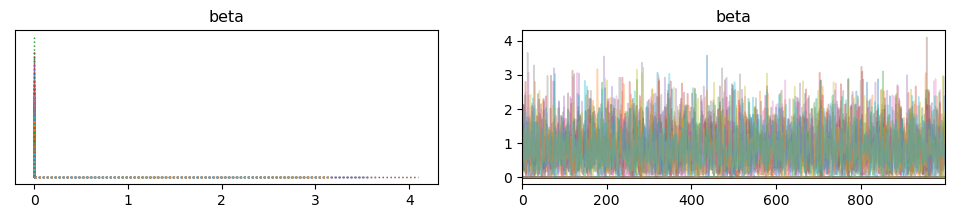

In [13]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag
az.plot_trace(idata,combined=True)

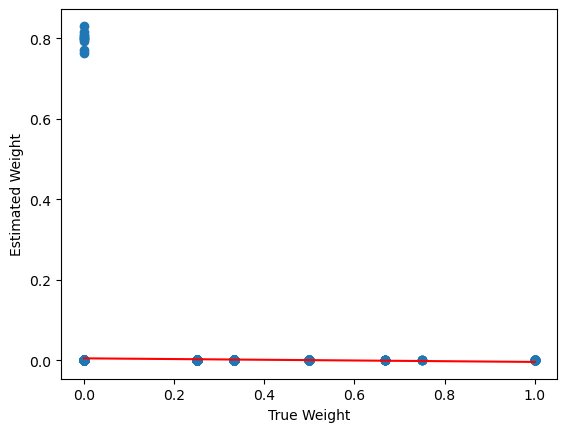

In [14]:
from scipy.stats import linregress
mean_post = np.mean(idata.posterior['beta'][0],axis=0)

plt.scatter(np.ravel(prop_vec), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()


In [19]:
def proportions(inp, n_clusts):
    props = np.zeros(n_clusts)
    prac = prac = np.unique(inp, return_counts=True)
    partial_props = prac[1]/sum(prac[1])
    count=0
    for o in range(len(props)):
        if o in prac[0]: 
            props[o] = partial_props[count]
            count+=1
    return(props)

In [25]:
n_clusts = 10
n_genes = 200 #TICK
n_cells = 600

#Sample random rates from a uniform distribution for each class and each gene
rate_mat = np.zeros((n_clusts, n_genes)) 
rate_mat = np.random.uniform(low=0, high=50, size=(rate_mat.shape)).astype(int) #TICK.
cell_rate_mat = np.repeat(rate_mat, 60, axis=0) #get the rates for each cell - 60 cells in each group with same rates #?

#Sample from Poisson for each cell given its cell type
cell_counts = np.random.poisson(cell_rate_mat, size=cell_rate_mat.shape)


In [51]:
#Generate spots
n_spots = 180

orig_cells = np.arange(0,cell_counts.shape[0]) 
#random.seed(10)
random.shuffle(orig_cells) #randomly shuffle indeces

#Define partioning - split into different groups of varying sizes
chunk_size = [np.ones(50), np.full(20, 2), np.full(27, 3), np.full(1, 4), np.full(61, 5), np.full(20,6)]
groups = np.split(orig_cells, np.cumsum(np.concatenate(chunk_size)).astype(int)) #group by chunk size


In [52]:
groups

[array([341]),
 array([538]),
 array([410]),
 array([490]),
 array([270]),
 array([4]),
 array([186]),
 array([317]),
 array([379]),
 array([144]),
 array([210]),
 array([461]),
 array([420]),
 array([117]),
 array([593]),
 array([289]),
 array([540]),
 array([586]),
 array([283]),
 array([198]),
 array([297]),
 array([372]),
 array([536]),
 array([159]),
 array([321]),
 array([427]),
 array([356]),
 array([589]),
 array([145]),
 array([546]),
 array([116]),
 array([257]),
 array([386]),
 array([1]),
 array([352]),
 array([201]),
 array([254]),
 array([407]),
 array([150]),
 array([369]),
 array([404]),
 array([533]),
 array([0]),
 array([590]),
 array([376]),
 array([45]),
 array([363]),
 array([58]),
 array([518]),
 array([351]),
 array([111, 131]),
 array([599, 280]),
 array([173, 308]),
 array([299, 245]),
 array([ 16, 276]),
 array([394, 564]),
 array([174,  54]),
 array([385, 358]),
 array([284, 102]),
 array([ 69, 466]),
 array([296, 154]),
 array([327, 428]),
 array([90, 14]),


In [42]:
len(groups)

179

In [53]:
#Create simulated spots and calculate true proportions
spots = np.zeros((len(groups), cell_counts.shape[1])) #spots x genes
prop_vec = np.zeros((len(groups),n_clusts))

#loop over each group
for g in range(len(groups)):
    spots[g] = np.sum(cell_counts[groups[g]], axis=0) #generate mix of gene expression
    prop_vec[g] = proportions((groups[g]/60).astype(int), n_clusts) #calculate the true proportions

In [54]:
#Calculate mean gene expression per group
curr = 0
ref_exp = np.zeros((n_clusts, n_genes))
for i in range(n_clusts):
    ref_exp[i] = np.mean(cell_counts[curr:curr+60,:], axis=0)
    curr+=60

In [55]:
ref_exp.shape

(10, 200)

In [57]:
spots

array([[  4.,  11.,  38., ...,  46.,   7.,   4.],
       [ 24.,  14.,   0., ...,  24.,  40.,  39.],
       [ 29.,  20.,   1., ...,   4.,  39.,  30.],
       ...,
       [149., 166., 111., ..., 171., 148., 130.],
       [ 87., 122., 118., ..., 104., 134., 155.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [67]:
#Run without logs
basic_model=pm.Model()

with basic_model:
    
    # alpha=pm.MvNormal("alpha", mu=0, cov=np.ones((200,200)), shape=(200,50))
    beta=pm.HalfNormal("beta", sigma=1, shape=(n_spots, n_clusts))
    
    lmd=pm.math.dot(beta, ref_exp)    

    #Calculate total counts to get Poisson rates
    N = np.sum(spots+1, axis=1) 
    N = np.asarray([N for i in range(n_genes)]).T #Repeat total counts across columns for elementwise multiplication

    #Likelihood of observed data given Poisson rates
    y=pm.Poisson("y", mu=lmd*N, observed=spots+1)
    

In [62]:
spots + 1

array([[  5.,  12.,  39., ...,  47.,   8.,   5.],
       [ 25.,  15.,   1., ...,  25.,  41.,  40.],
       [ 30.,  21.,   2., ...,   5.,  40.,  31.],
       ...,
       [150., 167., 112., ..., 172., 149., 131.],
       [ 88., 123., 119., ..., 105., 135., 156.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.]])

In [68]:
with basic_model:
    idata=pm.sample(draws=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 104 seconds.


array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

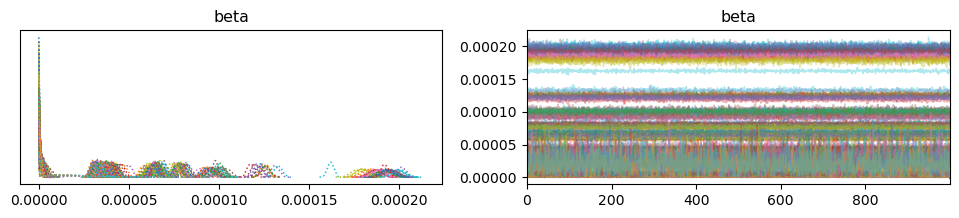

In [69]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag
az.plot_trace(idata,combined=True)

In [71]:
prop_vec[-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [75]:
np.mean(idata.posterior['beta'][0],axis=0)[-1]*1000

<xarray.DataArray 'beta' (beta_dim_1: 10)>
array([0.0218111 , 0.0195246 , 0.02094023, 0.01950591, 0.02312866,
       0.02169964, 0.02381533, 0.02192149, 0.01945598, 0.02131271])
Coordinates:
    chain       int64 0
    beta_dim_0  int64 179
  * beta_dim_1  (beta_dim_1) int64 0 1 2 3 4 5 6 7 8 9

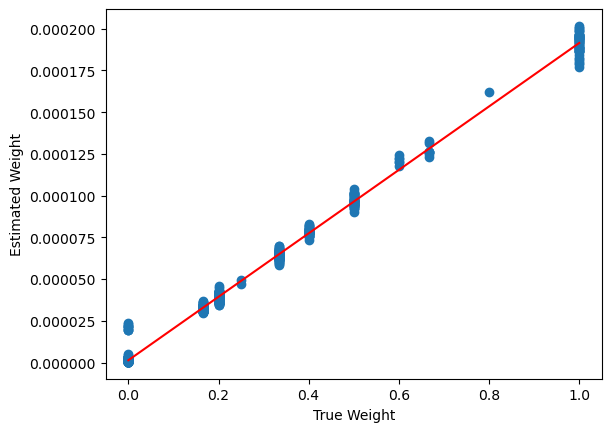

In [70]:
from scipy.stats import linregress
mean_post = np.mean(idata.posterior['beta'][0],axis=0)

plt.scatter(np.ravel(prop_vec), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()


array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

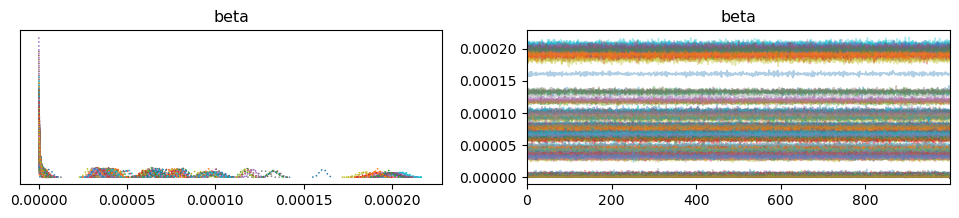

In [49]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag
az.plot_trace(idata,combined=True)

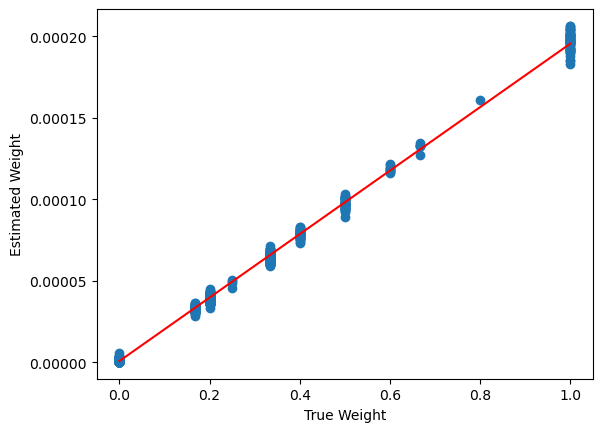

In [50]:
from scipy.stats import linregress
mean_post = np.mean(idata.posterior['beta'][0],axis=0)

plt.scatter(np.ravel(prop_vec), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()


In [20]:
#Create simulated spots and calculate true proportions
spots = np.zeros((len(groups), cell_counts.shape[1])) #spots x genes
prop_vec = np.zeros((len(groups),n_clusts))

#loop over each group
for g in range(len(groups)):
    spots[g] = np.sum(cell_counts[groups[g]], axis=0) #generate mix of gene expression
    prop_vec[g] = proportions((groups[g]/60).astype(int), n_clusts) #calculate the true proportions

In [ ]:
#Run without logs
basic_model=pm.Model()

with basic_model:
    
    # alpha=pm.MvNormal("alpha", mu=0, cov=np.ones((200,200)), shape=(200,50))
    beta=pm.HalfNormal("beta", sigma=1, shape=(n_spots, n_clusts))
    
    lmd=pm.math.dot(beta, ref_exp)    

    #Calculate total counts to get Poisson rates
    N = np.sum(spots, axis=1) 
    N = np.asarray([N for i in range(n_genes)]).T #Repeat total counts across columns for elementwise multiplication

    #Likelihood of observed data given Poisson rates
    y=pm.Poisson("y", mu=lmd*N, observed=spots)
    

In [18]:
#Calculate mean gene expression per group
curr = 0
ref_exp = np.zeros((n_clusts, n_genes))
for i in range(n_clusts):
    ref_exp[i] = np.mean(cell_counts[curr:curr+60,:], axis=0)
    curr+=60

In [36]:
#Run without logs
basic_model=pm.Model()

with basic_model:
    
    # alpha=pm.MvNormal("alpha", mu=0, cov=np.ones((200,200)), shape=(200,50))
    beta=pm.HalfNormal("beta", sigma=1, shape=(n_spots, n_clusts))
    
    lmd=pm.math.dot(beta, ref_exp)    

    #Calculate total counts to get Poisson rates
    N = np.sum(spots, axis=1) 
    N = np.asarray([N for i in range(n_genes)]).T #Repeat total counts across columns for elementwise multiplication

    #Likelihood of observed data given Poisson rates
    y=pm.Poisson("y", mu=lmd*N, observed=spots)
    

In [8]:
basic_model

beta ~ N**+(0, 1)
   y ~ Pois(f(beta))

In [37]:
with basic_model:
    idata=pm.sample(draws=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 324 seconds.


array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

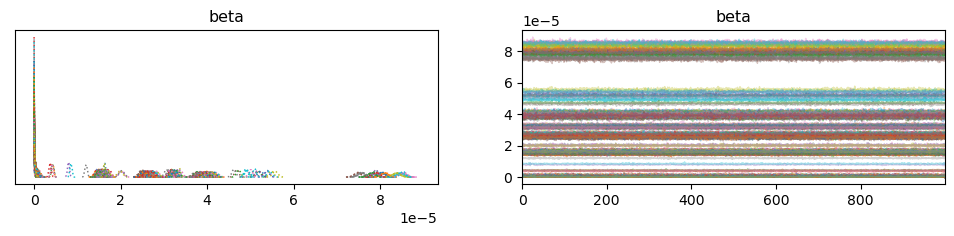

In [38]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag
az.plot_trace(idata,combined=True)

In [16]:
8*1e-5

8e-05

In [39]:
mean_post = np.mean(idata.posterior['beta'][0],axis=0)

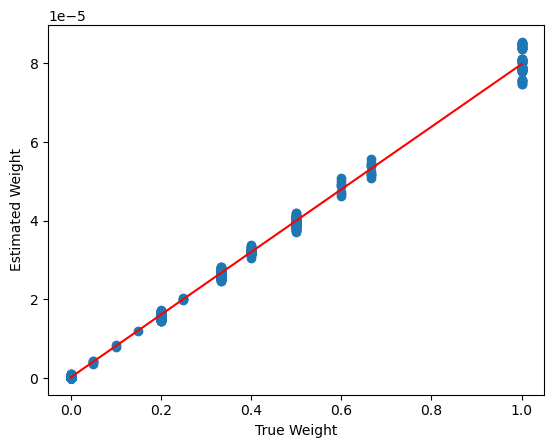

In [40]:
plt.scatter(np.ravel(prop_vec), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=scp.stats.linregress(np.ravel(prop_vec), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()


In [43]:
mean_beta

<xarray.DataArray 'beta' (beta_dim_0: 200, beta_dim_1: 10)>
array([[7.70537829e-05, 1.26001026e-07, 1.83178577e-07, ...,
        3.26455128e-07, 2.23969149e-07, 3.64569135e-07],
       [1.68193047e-07, 1.55447327e-07, 1.51181311e-07, ...,
        1.64776981e-07, 1.64286212e-07, 1.84377643e-07],
       [1.79176055e-07, 1.89860413e-07, 2.05494372e-07, ...,
        2.11882049e-07, 2.67728489e-07, 1.76008536e-07],
       ...,
       [2.94076836e-07, 7.20435383e-07, 1.61837132e-05, ...,
        1.57934425e-05, 3.31787100e-07, 1.83227078e-07],
       [1.95094809e-07, 3.76328825e-07, 1.50349510e-05, ...,
        1.60030801e-05, 2.78282090e-07, 2.78640627e-07],
       [1.59284945e-05, 4.27661269e-06, 4.09232761e-06, ...,
        1.23457777e-05, 1.62674852e-05, 8.21780133e-06]])
Coordinates:
    chain       int64 0
  * beta_dim_0  (beta_dim_0) int64 0 1 2 3 4 5 6 ... 193 194 195 196 197 198 199
  * beta_dim_1  (beta_dim_1) int64 0 1 2 3 4 5 6 7 8 9

In [53]:
mean_beta = np.mean(chain1,axis=0)
mean_beta.shape

(200, 10)

In [35]:
prop_vec.shape

(200, 10)

In [21]:
plt.scatter(np.ravel(prop_vec), np.ravel(mean_beta))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

NameError: name 'mean_beta' is not defined

In [ ]:
plt.scatter(np.ravel(tw_arr), np.ravel(normalized_mean_beta))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=scp.linregress(np.ravel(tw_arr), np.ravel(normalized_mean_beta))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()


In [32]:
mean_beta.shape

(200, 10)

In [6]:
import scipy.stats as scp

In [7]:
orig_counts=pd.read_csv("original_counts.csv")
ref=pd.read_csv("reference.csv")
metadata=pd.read_csv("simulated_metadata.csv")
spots=pd.read_csv("simulated_spots.csv")

In [8]:
spots["gene"][spots["gene"]=="NKG7"]

14    NKG7
Name: gene, dtype: object

In [9]:
rates = np.asarray(spots)[:,1:]/np.sum(np.asarray(spots)[:,1:], axis=0)

In [10]:
rates=rates*1e4

#log_rate=np.log(rates.astype('float64'))



In [11]:
#plt.hist(log_rate[14,:], bins = 100)
#plt.show()

In [12]:
ref = np.asarray(ref)*1e4

In [13]:
pd.DataFrame(ref)

,0,1,2,3,4,5,6,7,8
0,253.164557,729.166667,169.491525,145.348837,143.369176,864.197531,0.000000,312.5,407857.142857
1,6455.696203,462583.333333,8199.152542,6250.000000,5770.609319,109135.802469,5625.000000,673125.0,20000.000000
2,1533.052039,312020.833333,1970.338983,1569.767442,1648.745520,45432.098765,1388.888889,52500.0,7857.142857
3,84.388186,41.666667,148.305085,19854.651163,71.684588,1543.209877,138.888889,625.0,714.285714
4,1054.852321,1729.166667,1355.932203,843.023256,36881.720430,1358.024691,201944.444444,2500.0,714.285714
...,...,...,...,...,...,...,...,...,...
495,98.452883,479.166667,127.118644,58.139535,179.211470,1543.209877,277.777778,625.0,0.000000
496,506.329114,708.333333,487.288136,1569.767442,501.792115,1049.382716,416.666667,1562.5,0.000000
497,2869.198312,44000.000000,4216.101695,3808.139535,4480.286738,21790.123457,10694.444444,75625.0,9285.714286
498,42.194093,270.833333,254.237288,406.976744,35.842294,123.456790,0.000000,0.0,0.000000


In [14]:
pd.DataFrame(rates)

,0,1,2,3,4,5,6,7,8,9,...,835,836,837,838,839,840,841,842,843,844
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,93.457944,375.93985,0.0,736.196319,746.812386,635.294118,458.715596,106.382979,671.378092,0.0,...,888.888889,813.953488,1108.033241,63.291139,64.102564,123.45679,0.0,95.541401,0.0,81.967213
2,0.0,0.0,0.0,613.496933,346.083789,352.941176,114.678899,53.191489,459.363958,0.0,...,511.111111,581.395349,1246.537396,0.0,0.0,0.0,0.0,159.235669,0.0,40.983607
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,581.395349,122.699387,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.983607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,0.0,0.0,0.0,0.0,0.0,22.93578,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,0.0,75.18797,0.0,30.674847,109.289617,47.058824,114.678899,53.191489,70.671378,68.027211,...,133.333333,0.0,55.401662,63.291139,0.0,123.45679,0.0,63.694268,137.931034,40.983607
498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
ref.shape, rates.shape

((500, 9), (500, 845))

In [16]:
rates=rates.astype('float64')
ref=ref.astype('float64')

In [39]:
ncell=50
basic_model=pm.Model()

with basic_model:
    #alpha=pm.Normal("alpha", mu=0, sigma=1, shape=ncell)
    beta=pm.HalfNormal("beta",sigma=1, shape=(9, ncell))
    
    mu= pm.math.dot(ref, beta)
    
    y=pm.Poisson("y", mu, observed=rates[:,0:ncell])
    

In [40]:
ref.shape


(500, 9)

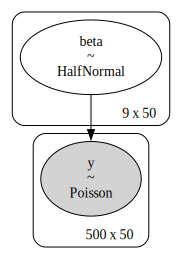

In [41]:
pm.model_to_graphviz(basic_model)

In [ ]:
with basic_model:
    idata=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta]


In [ ]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag
az.plot_trace(idata,combined=True)

In [ ]:
true_weights=pd.read_csv("true_weights.csv").iloc[:,0:ncell+1]

In [ ]:
true_weights

In [ ]:
chain1 = idata.posterior["beta"][0]
chain1.shape

In [ ]:
chain1=np.mean(chain1,axis=0)

In [ ]:
chain2 = idata.posterior["beta"][1]
chain2=np.mean(chain2,axis=0)

In [ ]:
mean_beta=chain1+chain2

In [ ]:
pd.DataFrame(mean_beta)

In [ ]:
normalized_mean_beta=np.asarray(mean_beta)/np.sum(np.asarray(mean_beta), axis=0)

In [ ]:
pd.DataFrame(normalized_mean_beta)


In [ ]:
true_weights.shape, normalized_mean_beta.shape

In [ ]:
true_weights

In [ ]:
tw_arr = np.asarray(true_weights)[:,1:]
tw_arr.shape, normalized_mean_beta.shape

In [ ]:
plt.scatter(np.ravel(tw_arr), np.ravel(normalized_mean_beta))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=scp.linregress(np.ravel(tw_arr), np.ravel(normalized_mean_beta))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()


In [ ]:
plt.plot(np.sum((tw_arr-normalized_mean_beta)**2, axis=0))
plt.show()